In [1]:
# importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Procesamiento de Datos

In [2]:
# obtener el conjunto de datos
df = pd.read_csv('heart.csv')

In [3]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<Axes: xlabel='output'>

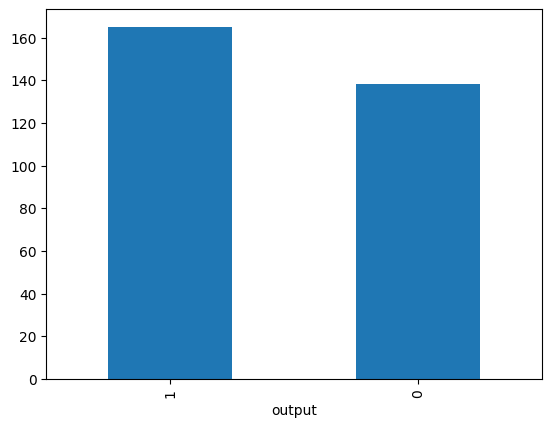

In [8]:
# see if the data is balance in a plot
df["output"].value_counts().plot(kind='bar')

In [10]:
# Verify if there are any null values
print(df.isna().sum())

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


In [11]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Transformación de Datos


In [327]:
def cate_pressure(df):
    if df["Systolic Pressure"] < 80 or df["Diastolic Pressure"] < 60 :
        return 0
    elif (df["Systolic Pressure"] >= 80 and df["Systolic Pressure"] <= 120) and (df["Diastolic Pressure"] >= 60 and df["Diastolic Pressure"] <= 80):
        return 1
    elif (df["Systolic Pressure"] > 120 and df["Systolic Pressure"] <= 129 ) and (df["Diastolic Pressure"] >= 60 and df["Diastolic Pressure"] <= 80):
        return 2
    elif (df["Systolic Pressure"] >= 130 and df["Systolic Pressure"] <= 139 ) or (df["Diastolic Pressure"] >= 80 and df["Diastolic Pressure"] <= 89):
        return 3
    elif (df["Systolic Pressure"] >= 140) or (df["Diastolic Pressure"] >= 90):
        return 4

In [328]:
from sklearn.preprocessing import LabelEncoder

#  ---------------------> CREAR COLUMNAS <---------------------

# Calcular la Frecuencia Cardíaca Máxima (FCM) usando la fórmula de Tanaka
df["FCM"] = 208 - (0.7 * df["Age"])

# Categorización del IMC
bins = [
    -1,
    18.5,
    24.9,
    29.9,
    100,
]  # Rangos para bajo peso, peso normal, sobrepeso y obeso
labels = [0, 1, 2, 3]
df["IMC"] = pd.cut(df["BMI"], bins=bins, labels=labels)

# Categorización de la Edad
age_bins = [-1, 18, 40, 100]  # Rangos para jóvenes, adultos y ancianos
age_labels = [0, 1, 2]
df["Age"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels)

# Frecuencia de Actividad Física
df["Physical_Activity_Frequency"] = pd.cut(
    df["Physical Activity Days Per Week"], bins=[-1, 2, 4, 10], labels=[0, 1, 2]
)

# Categorización del Hábito de Sueño
df["Sleep_Habit"] = pd.cut(
    df["Sleep Hours Per Day"], bins=[-1, 6, 9, 24], labels=[0, 1, 2]
)

# Razón Colesterol/Triglicéridos
df["Chol_Triglycerides_Ratio"] = df["Cholesterol"] / df["Triglycerides"]


# Índice de Riesgo de Estilo de Vida
df["Lifestyle_Risk_Index"] = (
    df["Smoking"]
    + df["Alcohol Consumption"]
    + df["Exercise Hours Per Week"]
    + df["Sedentary Hours Per Day"]
)

# ---------------------> LIMPIAR DATA / TRANSFORMAR DATA <---------------------

# Dividir la columna 'Blood Pressure' en dos columnas separadas
df[["Systolic Pressure", "Diastolic Pressure"]] = df["Blood Pressure"].str.split(
    "/", expand=True
)
df["Systolic Pressure"] = df["Systolic Pressure"].astype("int64")
df["Diastolic Pressure"] = df["Diastolic Pressure"].astype("int64")
df["PAM"] = (2 / 3 * df["Diastolic Pressure"]) + (
    1 / 3 * df["Systolic Pressure"]
)  # Calcular la Presión Arterial Media (PAM)
df["Categoric Pressure"] = df.apply(
    cate_pressure, axis=1
)  # Categorizar la Presión Arterial Media (PAM)

# Crear una columna con la razón Colesterol/IMC
df["Chol_BMI_ratio"] = df.apply(lambda r: float(r["Cholesterol"] / r["BMI"]), axis=1)

# ---------------------> DROP DATA <---------------------

df.drop(
    columns=[
        "Family History",
        "Obesity",
        "Diet",
        "Blood Pressure",
        "Cholesterol",
        "BMI",
        "Smoking",
        "Alcohol Consumption",
        "Exercise Hours Per Week",
        "Sedentary Hours Per Day",
        "Triglycerides",
        "Sleep Hours Per Day",
        "Physical Activity Days Per Week",
        "Income",
        "Country",
        "Continent",
        "Hemisphere",
    ],
    inplace=True,
)

# ---------------------> NORMALIZE DATA <---------------------

# Convertir las columnas a valores numéricos
le = LabelEncoder()

for columns in df.columns:
    if df[columns].dtype == "object":
        df[columns] = le.fit_transform(df[columns])

In [13]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [14]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
29,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
170,56,1,2,130,256,1,0,142,1,0.6,1,1,1,0
229,64,1,2,125,309,0,1,131,1,1.8,1,0,3,0
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1
105,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1


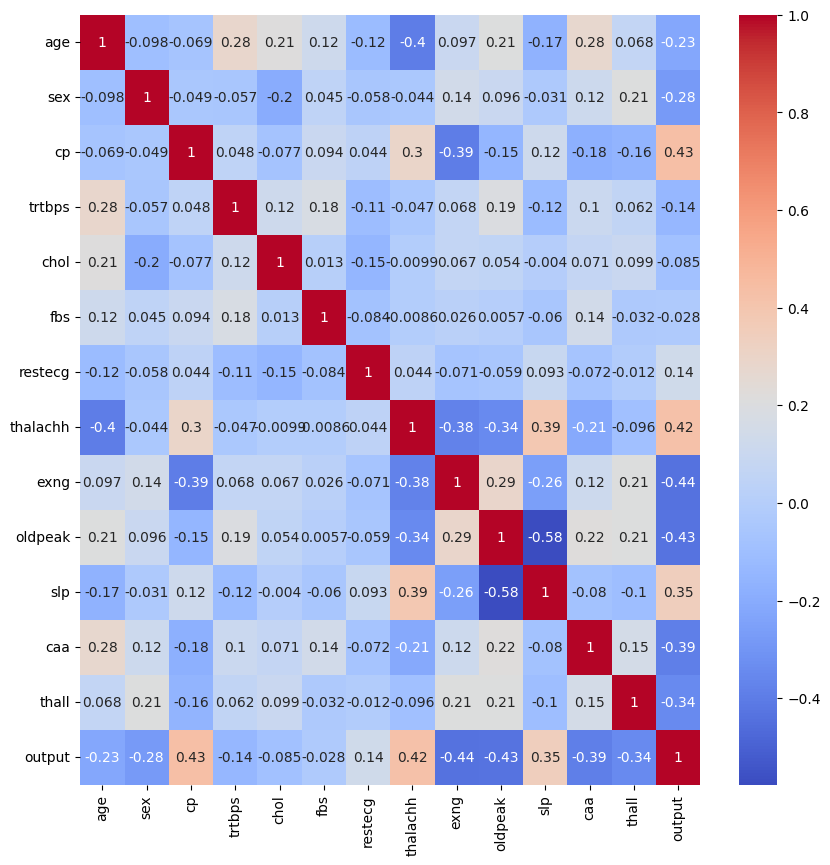

In [15]:
# graph of the corr
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

# Modelate

In [16]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
29,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
170,56,1,2,130,256,1,0,142,1,0.6,1,1,1,0
229,64,1,2,125,309,0,1,131,1,1.8,1,0,3,0
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1
105,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1


## Split Data

In [17]:
# Split the dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)


X_train, X_test, y_train, y_test = train_test_split(
    df.drop("output", axis=1),
    df["output"],
    random_state=42,
    test_size=0.2,
)

In [18]:
# Eliminamos el Id del pasajero en el conjunto de datos de prueba
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

## Model Perceptron


In [19]:
from sklearn.linear_model import Perceptron

In [20]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
predictions = perceptron.predict(X_test)
# Calculate his accuracy of the perceptron
acc_perceptron = accuracy_score(y_test, predictions)
# Print the accuracy
print(acc_perceptron)

0.639344262295082


## Model Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

In [22]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
# print accuracy
acc_gnb =accuracy_score(y_test, y_pred)
print(acc_gnb)

0.8524590163934426


## Model Regresion Logistic

In [23]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

### SGDClassifier

In [24]:
logistic_model_SGD = SGDClassifier(loss='log_loss',learning_rate='constant',eta0=0.1 ) # investicar los parámetros en la documentacion y variar el learning_rate
logistic_model_SGD.fit(X_train, y_train)

SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss')

In [25]:
print(f'Clases de la variable dependiente: {logistic_model_SGD.classes_}')
print('\n')
print('Vectores de coeficientes:')
print(logistic_model_SGD.coef_)

Clases de la variable dependiente: [0 1]


Vectores de coeficientes:
[[-6.81569825e+01 -1.36812588e+01  2.84310097e+01 -8.05636957e+01
  -1.09819610e+01 -9.83712481e-02  4.47054568e-01  1.25783195e+02
  -1.08471694e+01 -3.09643612e+01  1.25319645e+01 -2.68458551e+01
  -1.61550775e+01]]


In [26]:
y_pred = logistic_model_SGD.predict(X_train)

Accuracy entrenamiento: 0.6611570247933884
Matriz de confusión:


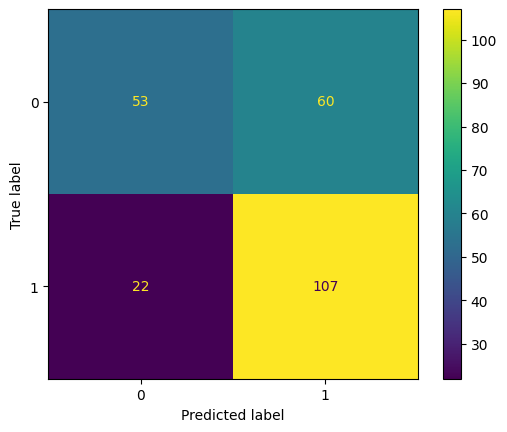

In [27]:
print(f'Accuracy entrenamiento: {accuracy_score(y_train, y_pred)}')
print('Matriz de confusión:')
matriz_confusion = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=logistic_model_SGD.classes_)
disp.plot()
plt.show()

In [28]:
y_pred_test = logistic_model_SGD.predict(X_test)

Accuracy testing: 0.7213114754098361
Matriz de confusión:


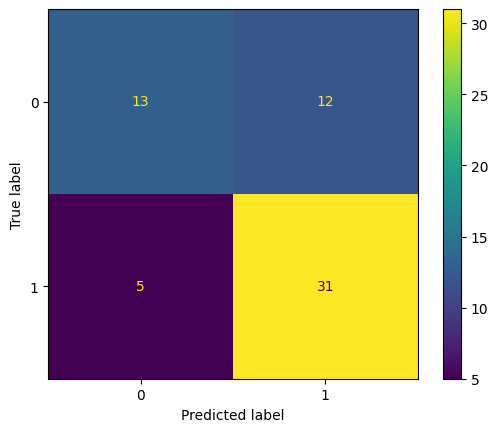

In [29]:
print(f'Accuracy testing: {accuracy_score(y_test, y_pred_test)}')
print('Matriz de confusión:')
matriz_confusion_test = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_test, display_labels=logistic_model_SGD.classes_)
disp.plot()
plt.show()

### LogisticRegression

In [31]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

d:\Codes\PC3-IA\.env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
print(f'Clases de la variable dependiente: {logistic_model.classes_}')
print('\n')
print('Vectores de coeficientes:')
print(logistic_model.coef_)

Clases de la variable dependiente: [0 1]


Vectores de coeficientes:
[[ 0.0044605  -1.41357237  0.68410376 -0.01410467 -0.00150852 -0.10791233
   0.35190126  0.03147495 -0.72355899 -0.48097766  0.56650423 -0.75576324
  -0.91740977]]


In [33]:
y_pred_2 = logistic_model.predict(X_train)

Accuracy entrenamiento: 0.8347107438016529
Matriz de confusión:


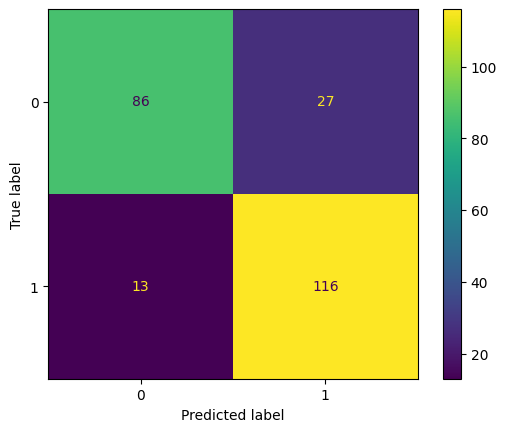

In [34]:
print(f'Accuracy entrenamiento: {accuracy_score(y_train, y_pred_2)}')
print('Matriz de confusión:')
matriz_confusion_2 = confusion_matrix(y_train, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_2, display_labels=logistic_model.classes_)
disp.plot()
plt.show()

In [35]:
y_pred_test_2 = logistic_model.predict(X_test)

Accuracy testing: 0.9180327868852459
Matriz de confusión:


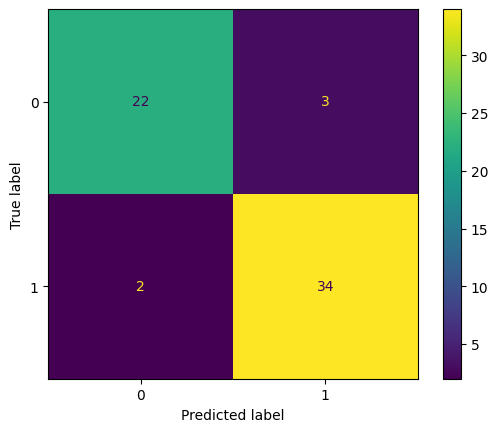

In [36]:
print(f'Accuracy testing: {accuracy_score(y_test, y_pred_test_2)}')
print('Matriz de confusión:')
matriz_confusion_test_2 = confusion_matrix(y_test, y_pred_test_2)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_test_2, display_labels=logistic_model.classes_)
disp.plot()
plt.show()

### ANN

In [37]:
# Use network neural
from keras.models import Sequential
from keras.layers import Dense, Input

In [38]:
## Con sequetial podemos construir una red neuronal apilando capas
modelsequ = Sequential()
modelsequ.add(Input(shape=(X_train.shape[1],)))
modelsequ.add(Dense(5, activation='relu'))
modelsequ.add(Dense(1, activation='sigmoid'))
modelsequ.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
modelsequ.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 70        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 76 (304.00 Byte)
Trainable params: 76 (304.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
historyseq = modelsequ.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=16,
    workers=4,
)

Epoch 1/500
16/16 [==============================] - 1s 12ms/step - loss: 23.0106 - accuracy: 0.5331 - val_loss: 16.0965 - val_accuracy: 0.5902
Epoch 2/500
16/16 [==============================] - 0s 3ms/step - loss: 13.9026 - accuracy: 0.5331 - val_loss: 7.8414 - val_accuracy: 0.5902
Epoch 3/500
16/16 [==============================] - 0s 3ms/step - loss: 4.8940 - accuracy: 0.4628 - val_loss: 3.3790 - val_accuracy: 0.3770
Epoch 4/500
16/16 [==============================] - 0s 3ms/step - loss: 3.2575 - accuracy: 0.3843 - val_loss: 2.9642 - val_accuracy: 0.4098
Epoch 5/500
16/16 [==============================] - 0s 3ms/step - loss: 2.6353 - accuracy: 0.3719 - val_loss: 2.5729 - val_accuracy: 0.4426
Epoch 6/500
16/16 [==============================] - 0s 3ms/step - loss: 2.4080 - accuracy: 0.3719 - val_loss: 2.3959 - val_accuracy: 0.4262
Epoch 7/500
16/16 [==============================] - 0s 3ms/step - loss: 2.1821 - accuracy: 0.3926 - val_loss: 2.1251 - val_accuracy: 0.4262
Epoch 8/5

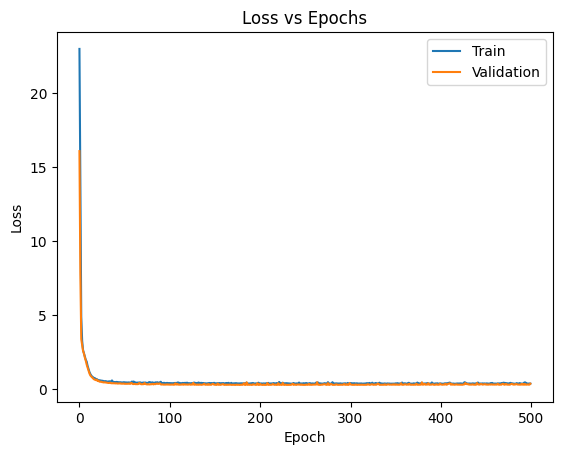

In [40]:
# graph of loss 
plt.plot(historyseq.history['loss'])
plt.plot(historyseq.history['val_loss'])
plt.title('Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### CNN

In [41]:
# Import lib for convolutional neural network
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

In [42]:
X_train.shape

(242, 13)

In [43]:
modelconv = Sequential()
# modelconv.add(tf.keras.Input(shape=(10,)))
modelconv.add(Conv1D(4, 3, activation="relu", input_shape=(X_train.shape[1], 1)))
modelconv.add(MaxPooling1D())
modelconv.add(Flatten())
modelconv.add(Dense(4, activation="relu"))
modelconv.add(Dropout(0.1))
modelconv.add(Dense(1, activation="sigmoid"))
modelconv.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
modelconv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11, 4)             16        
                                                                 
 max_pooling1d (MaxPooling1  (None, 5, 4)              0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 84        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                      

In [44]:
# Train the model
historyconv = modelconv.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=16
)

Epoch 1/500
16/16 [==============================] - 1s 11ms/step - loss: 0.7942 - accuracy: 0.5207 - val_loss: 0.7086 - val_accuracy: 0.4098
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 0.7059 - accuracy: 0.4545 - val_loss: 0.6889 - val_accuracy: 0.5902
Epoch 3/500
16/16 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5331 - val_loss: 0.6826 - val_accuracy: 0.5902
Epoch 4/500
16/16 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.4959 - val_loss: 0.6942 - val_accuracy: 0.4098
Epoch 5/500
16/16 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5372 - val_loss: 0.6798 - val_accuracy: 0.5902
Epoch 6/500
16/16 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.4752 - val_loss: 0.7039 - val_accuracy: 0.4098
Epoch 7/500
16/16 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4752 - val_loss: 0.6831 - val_accuracy: 0.5902
Epoch 8/500
